# FLEX approximation
Author: [Niklas Witt](mailto:niklas.witt@physik.uni-hamburg.de)

## Theory of FLEX in the paramagnetic state

The Fluctuation Exchange (FLEX) approximation is a perturbative diagrammatic method that was first introduced by Bickers et al. {cite:p}`Bickers89a,Bickers89b`. It can be derived from a Luttinger-Ward functional {cite:p}`Luttinger60` containing an infinite series of closed bubble and ladder diagrams. Physically, this means that in FLEX the exchange of spin and charge fluctuations is treated self-consistently. As such, it is suitable for studying systems with strong spin fluctuations, e.g., in Fermi liquids or near quantum critical points. Here, we want to give a code example of the single-orbital limit of FLEX with a local Hubbard interaction $U$ to illustrate the practical implementation of the `sparse-ir` package for diagrammatic methods.

For the implementation of a multi-orbital code, please have a look at {cite:p}`Witt21` and [FLEX_IR package](https://github.com/nikwitt/FLEX_IR).

#### Set of FLEX equations
We review the set of equations that need to be solved self-consistently in the FLEX approximation. The goal is to solve the Dyson equation

$$
\begin{align}
G(i\omega_n,\boldsymbol{k}) &= [G_0^{-1}(i\omega_n,\boldsymbol{k}) - \Sigma(i\omega_n,\boldsymbol{k})]^{-1} \\
& = [i\omega_n - (\varepsilon_{\boldsymbol{k}}-\mu) - \Sigma(i\omega_n,\boldsymbol{k})]^{-1}\;.
\end{align}
$$

for the interacting Green function $G$ from the non-interacting Green function $G_0(i\omega_n,\boldsymbol{k}) = [i\omega_n - (\varepsilon_{\boldsymbol{k}}-\mu)]^{-1}$ with single-particle dispersion $\varepsilon_{\boldsymbol{k}}$ and chemical potential $\mu$ as well as self-energy $\Sigma$ as a function of Matsubara frequencies $\omega_n=(2n+1)\pi T$ and momentum $\boldsymbol{k}$. Using the Green function, we calculate the irreducible susceptibility ("bubble diagram") as

$$ \chi_0(i\nu_m, \boldsymbol{q}) = - \frac{T}{N_{\boldsymbol{k}}} \sum_{n,\boldsymbol{k}} G(i\omega_n + i\nu_m, \boldsymbol{k} + \boldsymbol{q})G(i\omega_n, \boldsymbol{k})\;.$$

$N_{\boldsymbol{k}}$ denotes the number of $\boldsymbol{k}$-points. This equation is a convolution typical in diagrammatic methods. It can be easily evaluated by Fourier transforming to imaginary-time and real space, resulting in a simple multiplication

$$ \chi_0(\tau, \boldsymbol{r}) = - G(\tau, \boldsymbol{r})G(-\tau,-\boldsymbol{r}) = G(\tau, \boldsymbol{r})G(\beta-\tau,\boldsymbol{r})\;.$$

In our practical implementation, we will perform this step using the `sparse-ir` package. The infinite sum of bubble and ladder diagrams can be resummed to yield a Berk-Shrieffer type interaction {cite:p}`Berk1966`

$$ V(i\nu_m, \boldsymbol{q}) = \frac{3}{2} U^2 \chi_{\mathrm{s}}(i\nu_m, \boldsymbol{q}) + \frac{1}{2} U^2 \chi_{\mathrm{c}}(i\nu_m, \boldsymbol{q}) - U^2 \chi_0(i\nu_m, \boldsymbol{q}) + U $$

with spin and charge susceptibility like in the Random-Phase-Approximation (RPA) 

$$ \chi_{\mathrm{s}}(i\nu_m, \boldsymbol{q}) = \frac{\chi_0(i\nu_m, \boldsymbol{q})}{1-U\chi_0(i\nu_m, \boldsymbol{q})} \quad , \quad \chi_{\mathrm{c}}(i\nu_m, \boldsymbol{q}) = \frac{\chi_0(i\nu_m, \boldsymbol{q})}{1+U\chi_0(i\nu_m, \boldsymbol{q})}\;. $$

The self-energy can be calculated from the convolution

$$ \Sigma(i\omega_n, \boldsymbol{k}) = \frac{T}{N_{\boldsymbol{k}}} \sum_{m,\boldsymbol{q}} V(i\nu_m, \boldsymbol{q}) G(i\omega_n - i\nu_m, \boldsymbol{k} - \boldsymbol{q}) $$

which Fourier transformed to real space and imaginary-times takes the form

$$ \Sigma(\tau, \boldsymbol{r}) = V(\tau, \boldsymbol{r}) G(\tau, \boldsymbol{r})\;. $$

Thus, we have the set of self-consistent equations complete. In every iteration, the chemical potential $\mu$ needs to be adjusted to keep the electron density $n$ fixed. It can be calculated via solving

$$ n = 2n_{\sigma} = 2 - \frac{2}{N_{\boldsymbol{k}}} \sum_{\boldsymbol{k}} G(\tau=0^+, \boldsymbol{k}) $$

with a factor 2 from spin degeneracy and $0^+ = \lim_{\eta\to 0+} \eta$ by using some root finding algorithm like bisection method or Brent's method.

#### Notes on practical implementation
When implementing the fully self-consistent FLEX loop, a few points need to be treated carefully which we adress in the following:

* The constant Hartree term $V_{\mathrm{H}} = U$ in the interaction $V$ and respective self-energy term $\Sigma_H = U\frac{n}{2}$ can be absorbed into the definition of the chemical potential $\mu$. Otherwise we would have to treat them separately.
* We include a mixing $p<1$ in each iteration step, such that the Green function of step $n+1$ is partially constructed from the old and new Green function as $G^{n+1} = p\,G^{n+1} + (1-p)\,G^{n}$. This smoothes too strong oscillations of the solution.
* A bottleneck of the FLEX approximation is the case of too strong interactions. The solution turns numerically unstable, if the denominator of $\chi_{\mathrm{s}}$ approaches zero, i.e., $U\max\!\{\chi_{0}\} \to 1$. Typically, this can be solved by starting with a smaller $U$ value and slowly turning it up. We call this "$U$ renormalization".

## Code implementation
We implement the FLEX method for the simple case of a square lattice Hubbard model with dispersion $\varepsilon_{\boldsymbol{k}} = -2t\,[\cos(k_x) + \cos(k_y)]$ with nearest-neighbor hopping $t$ which sets the energy scale of our system (bandwidth $W = 8t$). First, we load all necessary basic modules that we are going to need in implementing FLEX and visualizing results:

In [1]:
import numpy as np
import scipy as sc
import scipy.optimize
from warnings import warn
import sparse_ir
%matplotlib inline
import matplotlib.pyplot as plt

#### Parameter setting

In [2]:
### System parameters
t    = 1      # hopping amplitude
W    = 8*t    # bandwidth
wmax = 10     # set wmax >= W

T    = 0.1    # temperature
beta = 1/T    # inverse temperature
n    = 0.85   # electron filling, here per spin per lattice site (n=1: half filling)
U    = 4      # Hubbard interaction

### Numerical parameters
nk1, nk2  = 24, 24    # number of k_points along one repiprocal crystal lattice direction k1 = kx, k2 = ky
nk        = nk1*nk2
IR_tol    = 1e-10     # accuary for l-cutoff of IR basis functions
sfc_tol   = 1e-4      # accuracy for self-consistent iteration
maxiter   = 30        # maximal number of iterations in self-consistent cycle
mix       = 0.2       # mixing parameter for new 
U_maxiter = 50        # maximal number of iteration steps in U renormalization loop

#### Generating meshes
We need to generate a $\boldsymbol{k}$-mesh as well as set up the IR basis functions on a sparse $\tau$ and $i\omega_n$ grid. Then we can calculate the dispersion on this mesh.
In addition, we set calculation routines to Fourier transform $k\leftrightarrow r$ and $\tau\leftrightarrow i\omega_n$ (via IR basis).

In [3]:
#### Initiate fermionic and bosonic IR basis objects
IR_basis_set = sparse_ir.FiniteTempBasisSet(beta, wmax, eps=IR_tol)

class Mesh:
    """
    Holding class for k-mesh and sparsely sampled imaginary time 'tau' / Matsubara frequency 'iw_n' grids.
    Additionally it defines the Fourier transform routines 'r <-> k'  and 'tau <-> l <-> wn'.
    """
    def __init__(self,IR_basis_set,nk1,nk2):
        self.IR_basis_set = IR_basis_set

        # generate k-mesh and dispersion
        self.nk1, self.nk2, self.nk = nk1, nk2, nk1*nk2
        self.k1, self.k2 = np.meshgrid(np.arange(self.nk1)/self.nk1, np.arange(self.nk2)/self.nk2)
        self.ek = -2*t*( np.cos(2*np.pi*self.k1) + np.cos(2*np.pi*self.k2) ).reshape(nk)

        # lowest Matsubara frequency index
        self.iw0_f = np.where(self.IR_basis_set.wn_f == 1)[0][0]
        self.iw0_b = np.where(self.IR_basis_set.wn_b == 0)[0][0]

        ### Generate a frequency-momentum grid for iwn and ek (in preparation for calculating the Green function)
        # frequency mesh (for Green function)
        self.iwn_f = 1j * self.IR_basis_set.wn_f * np.pi * T
        self.iwn_f_ = np.tensordot(self.iwn_f, np.ones(nk), axes=0)

        # ek mesh
        self.ek_ = np.tensordot(np.ones(len(self.iwn_f)), self.ek, axes=0)

    def smpl_obj(self, statistics):
        """ Return sampling object for given statistic """
        smpl_tau = {'F': self.IR_basis_set.smpl_tau_f, 'B': self.IR_basis_set.smpl_tau_b}[statistics]
        smpl_wn  = {'F': self.IR_basis_set.smpl_wn_f,  'B': self.IR_basis_set.smpl_wn_b }[statistics]
        return smpl_tau, smpl_wn

    
    def tau_to_wn(self, statistics, obj_tau):
        """ Fourier transform from tau to iw_n via IR basis """
        smpl_tau, smpl_wn = self.smpl_obj(statistics)

        obj_tau = obj_tau.reshape((smpl_tau.tau.size, self.nk1, self.nk2))
        obj_l   = smpl_tau.fit(obj_tau, axis=0)
        obj_wn  = smpl_wn.evaluate(obj_l, axis=0).reshape((smpl_wn.wn.size, self.nk))
        return obj_wn

    def wn_to_tau(self, statistics, obj_wn):
        """ Fourier transform from iw_n to tau via IR basis """
        smpl_tau, smpl_wn = self.smpl_obj(statistics)

        obj_wn  = obj_wn.reshape((smpl_wn.wn.size, self.nk1, self.nk2))
        obj_l   = smpl_wn.fit(obj_wn, axis=0)
        obj_tau = smpl_tau.evaluate(obj_l, axis=0).reshape((smpl_tau.tau.size, self.nk))
        return obj_tau

    
    def k_to_r(self,obj_k):
        """ Fourier transform from k-space to real space """
        obj_k = obj_k.reshape(-1, self.nk1, self.nk2)
        obj_r = np.fft.fftn(obj_k,axes=(1,2))
        obj_r = obj_r.reshape(-1, self.nk)
        return obj_r

    def r_to_k(self,obj_r):
        """ Fourier transform from real space to k-space """
        obj_r = obj_r.reshape(-1, self.nk1, self.nk2)
        obj_k = np.fft.ifftn(obj_r,axes=(1,2))/self.nk
        obj_k = obj_k.reshape(-1, self.nk)
        return obj_k

#### FLEX loop solver
We wrap the calculation steps of the FLEX loop in the `FLEXSolver` class. We use the `Mesh` class defined above to perform calculation steps.

In [4]:
class FLEXSolver:
    def __init__(self, mesh, U, n, sigma_init=0, sfc_tol=1e-4, 
                 maxiter=100, U_maxiter=10, mix=0.2, verbose=True):
        """
        Solver class to calculate the FLEX loop self-consistently.
        After initializing the Solver by `solver = FLEXSolver(mesh, U, n, **kwargs)` 
        it can be run by `solver.solve()`.
        """
        ## Set internal parameters for the solve 
        self.U = U
        self.n = n
        self.mesh = mesh
        self.sigma = sigma_init
        self.sfc_tol = sfc_tol
        self.maxiter = maxiter
        self.U_maxiter = U_maxiter
        self.mix = mix
        self.verbose = verbose
        
        ## Set initial Green function and irreducible susceptibility
        # NOT running the FLEXSolver.solve instance corresponds to staying on RPA level
        self.mu = 0
        self.mu_calc()
        
        self.gkio_calc(self.mu)
        self.grit_calc()
        self.ckio_calc()
    
    
    #%%%%%%%%%%% Loop solving instance
    def solve(self):
        """ FLEXSolver.solve() executes FLEX loop until convergence """
        # check whether U < U_crit! Otherwise, U needs to be renormalized.
        if np.amax(np.abs(self.ckio))*self.U >= 1:
            self.U_renormalization()
            
        # perform loop until convergence is reached:
        for it in range(self.maxiter):
            sigma_old = self.sigma
            self.loop()

            # check whether solution is converged.
            sfc_check = np.sum(abs(self.sigma-sigma_old))/np.sum(abs(self.sigma))

            if self.verbose:
                print(it, sfc_check)
            if sfc_check < self.sfc_tol:
                print("FLEX loop converged at desired accuracy")
                break
    
    def loop(self):
        """ FLEX loop """
        gkio_old = self.gkio
        
        self.V_calc()
        self.sigma_calc()
        
        self.mu_calc()
        self.gkio_calc(self.mu)
        self.gkio = self.mix*self.gkio + (1-self.mix)*gkio_old
        
        self.grit_calc()
        self.ckio_calc()


    #%%%%%%%%%%% U renormalization loop instance
    def U_renormalization(self):
        """ Loop for renormalizing U if Stoner enhancement U*max{chi0} >= 1. """
        print('WARNING: U is too large and the spin susceptibility denominator will diverge/turn unphysical!')
        print('Initiate U renormalization loop.')
    
        # save old U for later
        U_old = self.U
        # renormalization loop may run infinitely! Insert break condition after U_it_max steps
        U_it = 0
    
        while U_old*np.amax(np.abs(self.ckio)) >= 1:
            U_it += 1
        
            # remormalize U such that U*chi0 < 1
            self.U = self.U / (np.amax(np.abs(self.ckio))*self.U + 0.01)
            print(U_it, self.U, U_old)
        
            # perform one shot FLEX loop
            self.loop()
        
            # reset U
            self.U = U_old
        
            # break condition for too many steps
            if U_it == self.U_maxiter:
                print('U renormalization reached breaking point')
                break
        print('Leaving U renormalization...')
    
    
    #%%%%%%%%%%% Calculation steps
    def gkio_calc(self, mu):
        """ calculate Green function G(iw,k) """
        self.gkio = (self.mesh.iwn_f_ - (self.mesh.ek_ - mu) - self.sigma)**(-1)

    def grit_calc(self):
        """ Calculate real space Green function G(tau,r) [for calculating chi0 and sigma] """
        # Fourier transform
        grit = self.mesh.k_to_r(self.gkio)
        self.grit = self.mesh.wn_to_tau('F', grit)

    def ckio_calc(self):
        """ Calculate irreducible susciptibility chi0(iv,q) """
        ckio = self.grit * self.grit[::-1, :]

        # Fourier transform
        ckio = self.mesh.r_to_k(ckio)
        self.ckio = self.mesh.tau_to_wn('B', ckio)

    def V_calc(self):
        """ Calculate interaction V(tau,r) from RPA-like spin and charge susceptibility for calculating sigma """
        # check whether U is too large and give warning
        if np.amax(np.abs(self.ckio))*self.U >= 1:
            warn("U*max(chi0) >= 1! Paramagnetic phase is left and calculations will turn unstable!")
        
        # spin and charge susceptibility
        self.chi_spin   = self.ckio / (1 - self.U*self.ckio)
        self.chi_charge = self.ckio / (1 + self.U*self.ckio)

        V = 3/2*self.U**2 * self.chi_spin + 1/2*self.U**2 * self.chi_charge - self.U**2 * self.ckio
        # Constant Hartree Term V ~ U needs to be treated extra, since they cannot be modeled by the IR basis.
        # In the single-band case, the Hartree term can be absorbed into the chemical potential.

        # Fourier transform
        V = self.mesh.k_to_r(V)
        self.V = self.mesh.wn_to_tau('B', V)

    def sigma_calc(self):
        """ Calculate self-energy Sigma(iw,k) """
        sigma = self.V * self.grit
    
        # Fourier transform
        sigma = self.mesh.r_to_k(sigma)
        self.sigma = self.mesh.tau_to_wn('F', sigma)
    
    
    #%%%%%%%%%%% Setting chemical potential mu
    def calc_electron_density(self, mu):
        """ Calculate electron density from Green function """
        self.gkio_calc(mu)
        gio  = np.sum(self.gkio,axis=1)/self.mesh.nk
        g_l  = self.mesh.IR_basis_set.smpl_wn_f.fit(gio)
        g_tau0 = self.mesh.IR_basis_set.basis_f.u(0)@g_l
    
        n  = 1 + np.real(g_tau0)
        n  = 2*n #for spin
        return n

    def mu_calc(self):
        """ Find chemical potential for a given filling n0 via brent's root finding algorithm """
        n_calc = self.calc_electron_density
        n0 = self.n
        f  = lambda mu : n_calc(mu) - n0

        self.mu = sc.optimize.brentq(f, np.amax(self.mesh.ek)*3, np.amin(self.mesh.ek)*3)

### Execute FLEX loop

In [5]:
# initialize calculation
IR_basis_set = sparse_ir.FiniteTempBasisSet(beta, wmax, eps=IR_tol)
mesh = Mesh(IR_basis_set, nk1, nk2)
solver = FLEXSolver(mesh, U, n, sigma_init=0, sfc_tol=sfc_tol, maxiter=maxiter, U_maxiter=U_maxiter, mix=mix)

# perform FLEX loop
solver.solve()

Initiate U renormalization loop.
1 2.367980269378632 4
2 2.663153051191154 4
3 2.952843202009329 4
4 3.237266506955083 4
5 3.5175353711277118 4
6 3.795074778959605 4
Leaving U renormalization...
0 0.08757050701878047
1 0.14458517806202492
2 0.02249651696279002
3 0.011826075022234653
4 0.007576749380835071
5 0.005298268436795198
6 0.00386272608805154
7 0.0028737816637474534
8 0.0021584597623246072
9 0.0016284507934097837
10 0.0012315292636733055
11 0.0009331890338153228
12 0.0007086077737273392
13 0.000539411252357287
14 0.0004118689361430992
15 0.0003156315340171327


16 0.00024290673624969666
17 0.0001878023867978905
18 0.00014592983406558303
19 0.00011401152358509576
20 8.956735422511919e-05
FLEX loop converged at desired accuracy


#### Visualize results

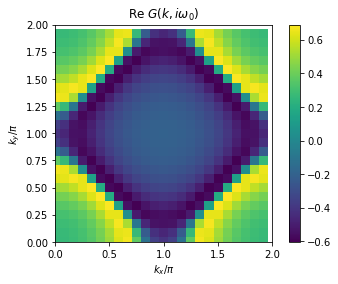

In [6]:
# plot 2D k-dependence of lowest Matsubara frequency of e.g. green function
plt.pcolormesh(2*mesh.k1.reshape(nk1,nk2), 2*mesh.k2.reshape(nk1,nk2), np.real(solver.gkio[mesh.iw0_f].reshape(mesh.nk1,mesh.nk2)), shading='auto')
ax = plt.gca()
ax.set_xlabel('$k_x/\pi$')
ax.set_xlim([0,2])
ax.set_ylabel('$k_y/\pi$')
ax.set_ylim([0,2])
ax.set_aspect('equal')
ax.set_title('Re $G(k,i\omega_0)$')
plt.colorbar()
plt.show()

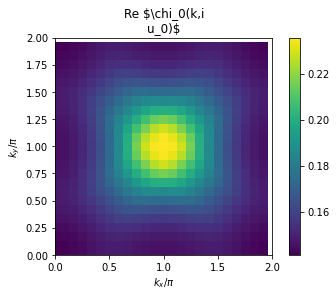

In [7]:
# plot 2D k-dependence of lowest Matsubara frequency of e.g. chi0
plt.pcolormesh(2*mesh.k1.reshape(nk1,nk2), 2*mesh.k2.reshape(nk1,nk2), np.real(solver.ckio[mesh.iw0_b].reshape(mesh.nk1,mesh.nk2)), shading='auto')
ax = plt.gca()
ax.set_xlabel('$k_x/\pi$')
ax.set_xlim([0,2])
ax.set_ylabel('$k_y/\pi$')
ax.set_ylim([0,2])
ax.set_aspect('equal')
ax.set_title('Re $\chi_0(k,i\nu_0)$')
plt.colorbar()
plt.show()

## Linearized Eliashberg equation
One example for which FLEX can be used is the description of superconductivity arising from spin-fluctuation-mediated pairing. While it is possible to perform FLEX calculations in the symmetry-broken state (Nambu phase), we will here focus on determining the superconducting critical temperature $T_{\mathrm{c}}$ by solving the linearized Eliashberg equation

$$
\begin{align}
\Delta^{(\xi)}(i\omega_n, \boldsymbol{k}) &= \frac{T}{N_{\boldsymbol{k}}} \sum_{m,\boldsymbol{q}} V^{(\xi)}(i\nu_m, \boldsymbol{q})F^{(\xi)}(i\omega_n - i\nu_m, \boldsymbol{k}-\boldsymbol{q}) \\
 &= -\frac{T}{N_{\boldsymbol{k}}} \sum_{m,\boldsymbol{q}} V^{(\xi)}(i\nu_m, \boldsymbol{q}) |G(i\omega_n - i\nu_m, \boldsymbol{k} - \boldsymbol{q})|^2 \Delta^{(\xi)}(i\omega_n - i\nu_m, \boldsymbol{k}-\boldsymbol{q})
\end{align}
 $$

for the gap function $\Delta$ ('order parameter') in either the spin singlet ($\xi=\mathrm{S}$) or spin triplet ($\xi=\mathrm{T}$) pairing channel. $F^{(\xi)} = -|G|^2\Delta^{(\xi)}$ is the anomalous Green function. Just like the convoluted sum for the self-energy, we can compute this equation easily after Fourier transforming to

$$
\begin{align}
\Delta^{(\xi)}(\tau, \boldsymbol{r}) = - V^{(\xi)}(\tau, \boldsymbol{r})F^{(\xi)}(\tau, \boldsymbol{r})\;.
\end{align}
$$

In each spin-pairing channel, the interaction is given by

$$
\begin{align}
    V^{(\xi=\mathrm{S})}(i\nu_m, \boldsymbol{q}) &= \frac{3}{2}U^2\chi_{\mathrm{s}}(i\nu_m, \boldsymbol{q}) - \frac{1}{2}U^2\chi_{\mathrm{c}}(i\nu_m, \boldsymbol{q}) + U\,,\\
    V^{(\xi=\mathrm{T})}(i\nu_m, \boldsymbol{q}) &= -\frac{1}{2}U^2\chi_{\mathrm{s}}(i\nu_m, \boldsymbol{q}) - \frac{1}{2}U^2\chi_{\mathrm{c}}(i\nu_m, \boldsymbol{q})\,.
\end{align}
$$

The gap equation is effectively an eigenvalue problem with $\Delta$ being the eigenvector and $\mathcal{K}\sim V |G|^2$ the matrix. Since we are only interested in the phase transition of the dominant symmetry pairing channel, we can solve for the largest eigenvalue $\lambda$ via the power method.

In this tutorial, we want to calculate the superconducting transition line for the dominant singlet $d\equiv d_{x^2-y^2}$-wave symmetric gap function. We initialize the calculation with a generic function of this symmetry (constant in frequency space):

$$
\Delta_{d}^0(\boldsymbol{k}) = \cos(k_x) - \cos(k_y)
$$

### Code implementation

#### Linearized Eliashberg solver

As for the FLEX loop, we implement a solver class that takes the `FLEXSolver` instance as an argument to solve the linearized Eliashberg equation.

In [8]:
class LinearizedGapSolver:
    def __init__(self, FLEX_solver, maxiter=50, sfc_tol=1e-4, verbose=True):
        """
        Solver class for solving the linearized gap equation using the power method.
        It takes FLEX results as an input.
        """
        
        ## Initialize necessary quantities from FLEX loop
        self.mesh = FLEX_solver.mesh
        self.gkio = FLEX_solver.gkio
        self.chi_spin = FLEX_solver.chi_spin
        self.chi_charge = FLEX_solver.chi_charge
        self.U = FLEX_solver.U
        
        self.maxiter = maxiter
        self.sfc_tol = sfc_tol
        self.verbose = verbose
        
        ## Initialize trial gap function
        # Here we focus on a d-wave symmetric solution
        self.delta0 = (np.cos(2*np.pi*self.mesh.k1) - np.cos(2*np.pi*self.mesh.k2)).reshape(self.mesh.nk)
        self.delta  = np.tensordot(np.ones(len(self.mesh.iwn_f)), self.delta0, axes=0)
        self.delta  = self.delta / np.linalg.norm(self.delta) # normalize initial guess
        
        ## Initialize interaction
        self.V_singlet_calc()
        
        ## Initialize eigenvalue
        self.lam = 0
        
    def solve(self):
        """ Solving instance to find eigenvalue from power method """
        for it in range(self.maxiter):
            lam_old = self.lam
            delta_old = self.delta
    
            self.frit_calc()
            delta = self.V_singlet * self.frit
    
            # Fourier transform to momentum space
            delta = self.mesh.r_to_k(delta)
            delta = self.mesh.tau_to_wn('F',delta)
    
            # calculate eigenvalue
            self.lam = np.real( np.sum(np.conj(delta)*delta_old) )
            self.delta = delta / np.linalg.norm(delta)
    
            if self.verbose:
                print(it, self.lam, abs(self.lam-lam_old))
            if abs(self.lam-lam_old) < self.sfc_tol:
                break   
    
    #%%%%%%%%%%% Calculation steps
    def V_singlet_calc(self):
        """ Set up interaction in real space and imaginary time """
    
        V = 3/2*self.U**2 * self.chi_spin - 1/2*self.U**2 * self.chi_charge
        # Constant Hartree Term V ~ U needs to be treated extra, since they cannot be modeled by the IR basis.
        # In the special case of d-wave symmetry, it can be neglected.
    
        # Fourier transform
        V = self.mesh.k_to_r(V)
        self.V_singlet = self.mesh.wn_to_tau('B', V)

    def frit_calc(self):
        """ Calculate (linearized) anomalous Green function F = |G|^2 * delta for evaluating the gap equation """
        self.fkio = - self.gkio*np.conj(self.gkio)*self.delta
        
        # Fourier transform
        frit = self.mesh.k_to_r(self.fkio)
        self.frit = self.mesh.wn_to_tau('F', frit)

#### Executing the gap equation solver

In [9]:
gap_solver = LinearizedGapSolver(solver, maxiter=maxiter, sfc_tol=sfc_tol)
gap_solver.solve()
print("The superconducting eigenvalue at T={} is lambda_d={:.3f}".format(T,gap_solver.lam))

0 0.10888121424964382 0.10888121424964382
1 0.4059012049261866 0.2970199906765428
2 0.4494744826665393 0.04357327774035269
3 0.4562291402541416 0.006754657587602297
4 0.45783189851144257 0.0016027582573009957
5 0.45821136458450473 0.0003794660730621624
6 0.45831339762103174 0.00010203303652700502
7 0.45833990178238465 2.650416135291378e-05
The superconducting eigenvalue at T=0.1 is lambda_d=0.458


#### Visualize results

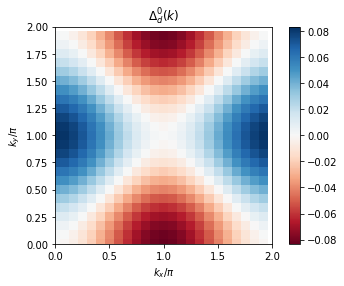

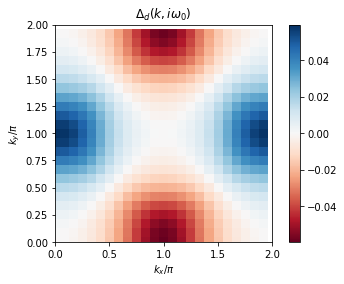

In [10]:
# plot 2D k-dependence of lowest Matsubara frequency of the gap vs. initial guess
plt.figure()
plt.pcolormesh(2*mesh.k1.reshape(nk1,nk2), 2*mesh.k2.reshape(nk1,nk2), np.real(gap_solver.delta0.reshape(nk1,nk2)) / np.linalg.norm(gap_solver.delta0), cmap='RdBu', shading='auto')
ax = plt.gca()
ax.set_xlabel('$k_x/\pi$')
ax.set_xlim([0,2])
ax.set_ylabel('$k_y/\pi$')
ax.set_ylim([0,2])
ax.set_aspect('equal')
ax.set_title('$\\Delta^0_d(k)$')
plt.colorbar()

plt.figure()
plt.pcolormesh(2*mesh.k1.reshape(nk1,nk2), 2*mesh.k2.reshape(nk1,nk2), np.real(gap_solver.delta[mesh.iw0_f].reshape(mesh.nk1,mesh.nk2)), cmap='RdBu', shading='auto')
ax = plt.gca()
ax.set_xlabel('$k_x/\pi$')
ax.set_xlim([0,2])
ax.set_ylabel('$k_y/\pi$')
ax.set_ylim([0,2])
ax.set_aspect('equal')
ax.set_title('$\\Delta_d(k,i\omega_0)$')
plt.colorbar()
plt.show()

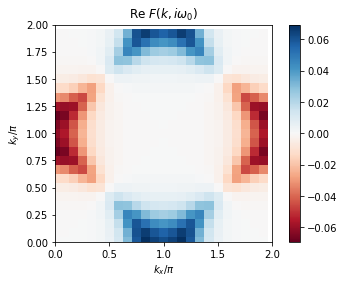

In [11]:
# plot 2D k-dependence of lowest Matsubara frequency of the anomalous Green function
plt.figure()
plt.pcolormesh(2*mesh.k1.reshape(nk1,nk2), 2*mesh.k2.reshape(nk1,nk2), np.real(gap_solver.fkio[mesh.iw0_f].reshape(mesh.nk1,mesh.nk2)), cmap='RdBu', shading='auto')
ax = plt.gca()
ax.set_xlabel('$k_x/\pi$')
ax.set_xlim([0,2])
ax.set_ylabel('$k_y/\pi$')
ax.set_ylim([0,2])
ax.set_aspect('equal')
ax.set_title('Re $F(k,i\omega_0)$')
plt.colorbar()
plt.show()

## Example: Antiferromagnetic fluctuations and $d$-wave superconductivity in the square-lattice Hubbard model
In this section, we will reproduce Figs. 3(b) and 4 of {cite:p}`Arita00` or respective Fig. 2(a) of {cite:p}`Witt21` using the SparseIR FLEX code developed above. It shows (i) the momemtum dependence of the static spin susceptibility and (ii) the temperature dependence of the superconducting eigenvalue $\lambda_d$ (as calculated above) and the inverse maximal spin susceptibility $1/\chi_{\mathrm{s,max}}$, which indicates tendency towards (quasi-)magnetic ordering.

In order to perform calculations for different $T$, we will initiate the IR basis with a $\Lambda = \beta_{\mathrm{max}}\omega_{\mathrm{max}}$ that is sufficient for the lowest temperature $T_{\mathrm{min}} = 1/\beta_{\mathrm{max}}$ we plan to do calculations for. Since $T$ changes, we have to recalculate the IR basis set instance for every step. We start from high $T$ and lower its value and initialize each $T$ calculation by using the previously converged solution, since it does not change drastically and speeds up convergence.

You can simply execute the following two code blocks which will first perform the calculation and then generate a figure similar to those in the references above.

In [12]:
#%%%%%%%%%%%%%%% Parameter settings
print('Initialization...')
# system parameters
t    = 1      # hopping amplitude
n    = 0.85   # electron filling, here per spin per lattice site (n=1: half filling)
U    = 4      # Hubbard interaction

W    = 8*t    # bandwidth
wmax = 10     # set wmax >= W
T_values = np.array([0.08,0.07,0.06,0.05,0.04,0.03,0.025])   # temperature

# numerical parameters
nk1, nk2  = 64, 64    # k-mesh sufficiently dense!
nk        = nk1*nk2
IR_Lambda = 10**3     # dimensionless IR parameter >= w_max * beta_min = 400
IR_tol    = 1e-8      # accuary for l-cutoff of IR basis functions
sfc_tol   = 1e-4      # accuracy for self-consistent iteration
it_max    = 30        # maximal number of iterations in self-consistent cycle
mix       = 0.2       # mixing parameter for new 
U_it_max  = 50        # maximal number of iteration steps in U renormalization loop

# initialize first IR basis set (no recalculation afterwrds)
beta_init = 1/T_values[0]
IR_basis_set = sparse_ir.FiniteTempBasisSet(beta_init, IR_Lambda/beta_init, eps=IR_tol)

# set initial self_energy - will be set to previous calculation step afterwards
sigma_init = 0

# empty arrays for results
lam_T     = np.empty((len(T_values)))
chiSmax_T = np.empty((len(T_values)))


#%%%%%%%%%%%%%%% Calculations for different T values
for T_it, T in enumerate(T_values):
    print("Now: T = {}".format(T))
    beta = 1/T

    # initialize meshes
    IR_basis_set = sparse_ir.FiniteTempBasisSet(beta, IR_Lambda/beta, eps=IR_tol, sve_result=IR_basis_set.sve_result)
    mesh = Mesh(IR_basis_set, nk1, nk2)
    
    # calculate FLEX loop
    solver = FLEXSolver(mesh, U, n, sigma_init=sigma_init, sfc_tol=sfc_tol, 
                        maxiter=maxiter, U_maxiter=U_maxiter, mix=mix, verbose=False)
    solver.solve()
    sigma_init = solver.sigma

    # calculate linearized gap equation
    gap_solver = LinearizedGapSolver(solver, maxiter=maxiter, sfc_tol=sfc_tol, verbose=False)
    gap_solver.solve()
    
    # save data for plotting
    lam_T[T_it] = gap_solver.lam#
    chiSmax_T[T_it] = np.real(np.amax(solver.chi_spin))
    
    if T == 0.03:
        chi_s_plt = np.real(solver.chi_spin)[mesh.iw0_b].reshape(mesh.nk1,mesh.nk2)

Initialization...


Now: T = 0.08


Initiate U renormalization loop.
1 2.2871467301181765 4
2 2.485684699365719 4
3 2.689077995746417 4


4 2.8952475057705347 4
5 3.100419429977408 4
6 3.306837871266046 4


7 3.5156369028925534 4
8 3.7272843212881654 4
9 3.941717267157532 4


Leaving U renormalization...


FLEX loop converged at desired accuracy


Now: T = 0.07


FLEX loop converged at desired accuracy


Now: T = 0.06


FLEX loop converged at desired accuracy


Now: T = 0.05


FLEX loop converged at desired accuracy


Now: T = 0.04


FLEX loop converged at desired accuracy


Now: T = 0.03


FLEX loop converged at desired accuracy


Now: T = 0.025


FLEX loop converged at desired accuracy


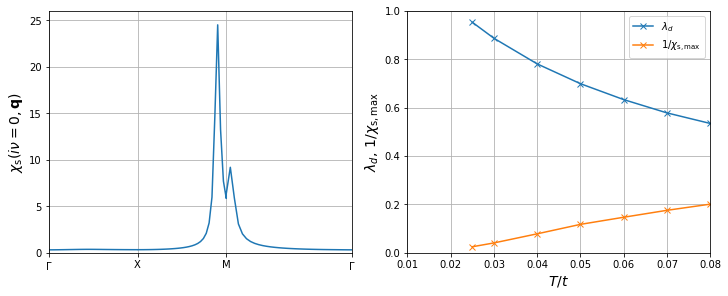

In [13]:
#%%%%%%%%%%%%%%%% Plot results in a combined figure
import matplotlib.gridspec as gridspec

fig   = plt.figure(figsize=(10,4),constrained_layout=True)
spec  = gridspec.GridSpec(ncols=2, nrows=1, figure=fig)
f_ax1 = fig.add_subplot(spec[0, 0])
f_ax2 = fig.add_subplot(spec[0, 1])

# first panel with momentum dependence of static spin susceptibility
k_HSP = np.concatenate((np.linspace(0,1,mesh.nk1//2),
                        np.linspace(1,2,mesh.nk2//2),
                        np.linspace(2,2+np.sqrt(2),mesh.nk1//2)))
chi_s_HSP = np.concatenate((chi_s_plt[:mesh.nk1//2, 0],
                          chi_s_plt[mesh.nk1//2, :mesh.nk2//2],
                          [chi_s_plt[it,it] for it in range(mesh.nk1//2)][::-1]))

f_ax1.plot(k_HSP, chi_s_HSP,'-')
f_ax1.set_xlim([0,2+np.sqrt(2)])
f_ax1.set_xticks([0,1,2,2+np.sqrt(2)])
f_ax1.set_xticklabels(['$\Gamma$','X','M','$\Gamma$'])
f_ax1.set_ylim([0,26])
f_ax1.set_xlabel('')
f_ax1.set_ylabel('$\\chi_{\\mathrm{s}}(i\\nu=0,{\\bf{q}})$', fontsize=14)
f_ax1.grid()

# second panel with T-dependence of lambda_d and 1/chi_s,max
f_ax2.plot(T_values, lam_T, '-x', label='$\lambda_d$')
f_ax2.plot(T_values, 1/chiSmax_T, '-x', label='$1/\chi_{\mathrm{s},\mathrm{max}}$')
f_ax2.set_xlim([0.01,0.08])
f_ax2.set_ylim([0,1])
f_ax2.set_xlabel('$T/t$', fontsize=14)
f_ax2.set_ylabel('$\lambda_d$, $1/\chi_{\mathrm{s},\mathrm{max}}$', fontsize=14)
f_ax2.legend()
f_ax2.grid()
plt.show()